#### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import backend as K
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


#### Define the data directories

In [2]:
csv_path = 'D:/Data for machine learning/Sartorius cell instance segmentation/train.csv'
data_path = 'D:/Data for machine learning/Sartorius cell instance segmentation/train/'

#### Data Loading and Preprocessing

In [3]:
# Load the CSV file containing image metadata
df = pd.read_csv(csv_path, usecols=['id', 'cell_type'])

# Add the full image path to the DataFrame
df['path'] = data_path + df['id'] + '.png'

# Rename the 'cell_type' column to 'label'
df = df.rename(columns={'cell_type': 'label'})

# Extract unique labels
classes = df['label'].unique()

# Create a label encoding dictionary
label_dict = {'shsy5y': 0, 'astro': 1, 'cort': 2}

# Encode labels
df['label'] = df['label'].replace(label_dict)

# Create a reverse label encoding dictionary
rev_label_dict = {b: a for a, b in label_dict.items()}

# Print dataset size and labels
print(f'Dataset size: {df.shape[0]}')
print(f'Labels: {classes[0]}, {classes[1]}, {classes[2]}')
df.head()

Dataset size: 73585
Labels: shsy5y, astro, cort


,id,label,path
0,0030fd0e6378,0,D:/Data for machine learning/Sartorius cell in...
1,0030fd0e6378,0,D:/Data for machine learning/Sartorius cell in...
2,0030fd0e6378,0,D:/Data for machine learning/Sartorius cell in...
3,0030fd0e6378,0,D:/Data for machine learning/Sartorius cell in...
4,0030fd0e6378,0,D:/Data for machine learning/Sartorius cell in...


#### Plot Last Image of Each Label

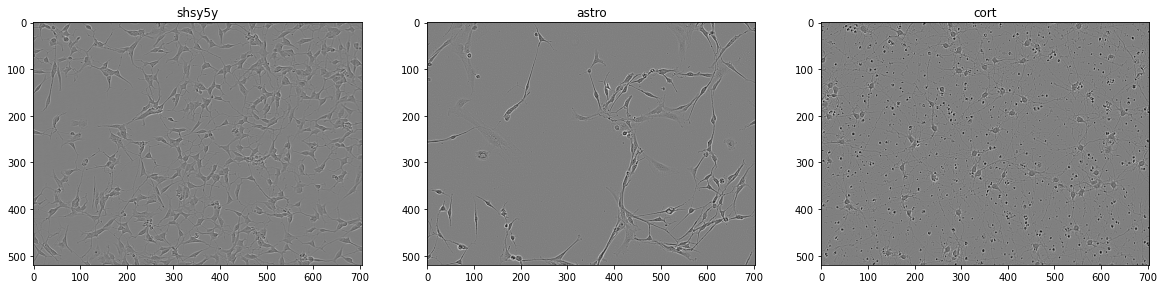

In [4]:
# Get the last image for each label
last_shsy5y = df[df['label'] == 0].iloc[-1]['path']
last_astro = df[df['label'] == 1].iloc[-1]['path']
last_cort = df[df['label'] == 2].iloc[-1]['path']

# Read the images
img_shsy5y = cv2.imread(last_shsy5y)
img_astro = cv2.imread(last_astro)
img_cort = cv2.imread(last_cort)

# Plot the images
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(img_shsy5y)
plt.title('shsy5y')
plt.subplot(132)
plt.imshow(img_astro)
plt.title('astro')
plt.subplot(133)
plt.imshow(img_cort)
plt.title('cort')
plt.show()

#### Load and Resize Images

In [5]:
# Define the target size
target_size = (100, 100)

# Initialize lists to store image data and labels
img_dataset = []
img_labels = []

# Load images from the specified paths in the train dataframe using a progress bar

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    image_path = row['path']
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, target_size)
    label = row['label']
    image = image.astype('float32')
    img_dataset.append(image)
    img_labels.append(label)

print("Images are loaded in define size...")

100%|██████████| 73585/73585 [04:51<00:00, 252.06it/s]

Images are loaded in define size...


#### Convert Lists to Numpy Arrays

In [6]:
X = np.asarray(img_dataset)
L = np.asarray(img_labels)

#### Reshape Data for Model Input

In [7]:
if K.image_data_format() == 'channels_first':
    X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])
    input_shape = (1, X.shape[1], X.shape[2])
else:
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    input_shape = (X.shape[1], X.shape[2], 1)

#### Data Preprocessing and Splitting

In [8]:
# One-hot encode labels
L = to_categorical(L, num_classes=len(classes))

# Normalization
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X - mean) / std

# Split data into training, validation, and test sets
X_train, X_test, L_train, L_test = train_test_split(X, L, test_size=0.2, random_state=4)

# Print data sizes
print("Train size:", X_train.shape)
print("Test size", X_test.shape)

Train size: (58868, 100, 100, 1)
Test size (14717, 100, 100, 1)


#### Define and Compile the Model

In [9]:
# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

# Compile the model
model.compile(Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 33856)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4333696   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

#### Training the Model

In [10]:
# Define early stopping to prevent overfitting and save the best model weights
early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True)

# Fit the model using data generator for training data and validation data
model.fit(X_train, L_train, epochs=4, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Train on 47094 samples, validate on 11774 samples
Epoch 1/4
47094/47094 [==============================] - 158s 3ms/step - loss: 0.1289 - accuracy: 0.9619 - val_loss: 8.7489e-05 - val_accuracy: 1.0000
Epoch 2/4
47094/47094 [==============================] - 108s 2ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 3.5087e-06 - val_accuracy: 1.0000
Epoch 3/4
47094/47094 [==============================] - 108s 2ms/step - loss: 0.0240 - accuracy: 0.9939 - val_loss: 2.6704e-06 - val_accuracy: 1.0000
Epoch 4/4
47094/47094 [==============================] - 108s 2ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 5.0318e-06 - val_accuracy: 1.0000


#### Evaluate the Model

In [11]:
test_loss, test_accuracy = model.evaluate(X_test, L_test, batch_size=64)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

14717/14717 [==============================] - 12s 817us/step
Test Loss: 2.852393898571419e-06
Test Accuracy: 1.0


#### Plotting the Confusion Matrix

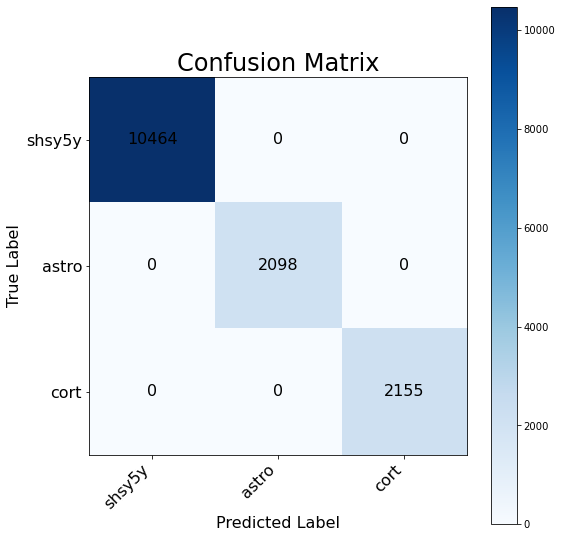

In [12]:
# Get predictions for the test set
y_pred = model.predict_classes(X_test)

# Generate confusion matrix
cm = confusion_matrix(L_test.argmax(axis=1), y_pred)

# Normalize confusion matrix (optional)
# cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8), facecolor='white')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=24)
plt.colorbar()

# Print class labels on x and y axes
class_names = [rev_label_dict[i] for i in range(len(classes))]
plt.xticks(np.arange(len(classes)), class_names, rotation=45, ha='right', fontsize=16)
plt.yticks(np.arange(len(classes)), class_names, fontsize=16)

# Print values inside confusion matrix cells
for i in range(len(classes)):
  for j in range(len(classes)):
    plt.text(j, i, cm[i, j], ha='center', va='center', fontsize=16)

plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix.jpg')
plt.show()

#### Saving the Trained Model

In [13]:
model_json = model.to_json()
json_file = open("sartorius_model.json", "w")
json_file.write(model_json)   
model.save_weights("sartorius_model_weights.h5")
json_file.close()

print("Model saved successfully to the script's directory   ;)!")

Model saved successfully to the script's directory   ;)!
